In [1]:
import xarray as xr
import numpy as np
import xoak
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
import tqdm
from itertools import zip_longest
from functools import reduce
from operator import add
from pathlib import Path


In [20]:
ds_traj = xr.open_zarr('/gxfs_work/geomar/smomw662/FESOMparcels_first/data/Parcels_run_1960-01-01.zarr')
#ds_traj = ds_traj.compute()
ds_traj

<xarray.Dataset> Size: 6GB
Dimensions:     (trajectory: 10000, obs: 30000)
Coordinates:
  * obs         (obs) int32 120kB 0 1 2 3 4 5 ... 29995 29996 29997 29998 29999
  * trajectory  (trajectory) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
Data variables:
    lat         (trajectory, obs) float32 1GB dask.array<chunksize=(10000, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 1GB dask.array<chunksize=(10000, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 2GB dask.array<chunksize=(10000, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 1GB dask.array<chunksize=(10000, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DperiodicBCCheckError
    parcels_mesh:           spherical
    parcels_version:        3.0.5

### Functions

In [25]:
def line_between(start,end):
    """Find the intermediate points on a line from (x0,y0) to (x1,y1).

    Parameters
    ------------
    start: tuple
        Contains x0 and y0
    end: tuple
        Contains x1 and y1

    Returns
    --------
    list
        List of all intermediate points (x,y)

    """
    x0,y0 = start
    x1,y1 = end
    #This extracts the individual coordinates from the start and end tuples.
    N = max(abs(x1 - x0) + 1, abs(y1 - y0) + 1) #calculate the number of steps
    #Calculate the incremental step sizes
    dx = (x1 - x0) / (N - 1) #for stepping in lon or x
    dy = (y1 - y0) / (N - 1) #for stepping in lat or y
    #the steps secure the evenly spaced points between the start and end

    #Generate the intermediate points
    xx = (round(x0 + n * dx) for n in range(N))
    yy = (round(y0 + n * dy) for n in range(N))
    #Combines the x and y coordinates into a list of tuples 
    return list(zip(xx,yy))

def line_between_sequence(points):
    """ Fill in lines on all segments of points.

    Parameters
    ----------
    points: list
        List of points (x,y).

    Returns
    -------
    list
        List of points(x,y) with all segments filled in.

    """

    segments = [
    line_between(start,end)[:-1]
    for start, end in zip(points[:-1], points[1:])
    ] + [points[-1:], ]
    return reduce(add, segments)

In [72]:
import numpy as np
import matplotlib.pyplot as plt


def map_hist(x, y, h, bins):
    xi = np.digitize(x, bins[0]) - 1
    yi = np.digitize(y, bins[1]) - 1
    inds = np.ravel_multi_index((xi, yi),
                                (len(bins[0]) - 1, len(bins[1]) - 1),
                                mode='clip')
    vals = h.flatten()[inds]
    bads = ((x < bins[0][0]) | (x > bins[0][-1]) |
            (y < bins[1][0]) | (y > bins[1][-1]))
    vals[bads] = np.NaN
    return vals


def scatter_hist2d(x, y,
                   s=20, marker=u'o',
                   mode='mountain',
                   bins=10, range=None,
                   normed=False, weights=None,  # np.histogram2d args
                   ax=None, dens_func=None,
                   **kwargs):
    """
    Make a scattered-histogram plot.

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data

    s : scalar or array_like, shape (n, ), optional, default: 20
        size in points^2.

    marker : `~matplotlib.markers.MarkerStyle`, optional, default: 'o'
        See `~matplotlib.markers` for more information on the different
        styles of markers scatter supports. `marker` can be either
        an instance of the class or the text shorthand for a particular
        marker.

    mode: [None | 'mountain' | 'valley' | 'clip']
       Possible values are:

       - None : The points are plotted as one scatter object, in the
         order in-which they are specified at input.

       - 'mountain' : The points are sorted/plotted in the order of
         the number of points in their 'bin'. This means that points
         in the highest density will be plotted on-top of others. This
         cleans-up the edges a bit, the points near the edges will
         overlap.

       - 'valley' : The reverse order of 'mountain'. The low density
         bins are plotted on top of the high ones.

    bins : int or array_like or [int, int] or [array, array], optional
        The bin specification:

          * If int, the number of bins for the two dimensions (nx=ny=bins).
          * If array_like, the bin edges for the two dimensions
            (x_edges=y_edges=bins).
          * If [int, int], the number of bins in each dimension
            (nx, ny = bins).
          * If [array, array], the bin edges in each dimension
            (x_edges, y_edges = bins).
          * A combination [int, array] or [array, int], where int
            is the number of bins and array is the bin edges.

    range : array_like, shape(2,2), optional
        The leftmost and rightmost edges of the bins along each dimension
        (if not specified explicitly in the `bins` parameters):
        ``[[xmin, xmax], [ymin, ymax]]``. All values outside of this range
        will be considered outliers and not tallied in the histogram.

    normed : bool, optional
        If False, returns the number of samples in each bin. If True,
        returns the bin density ``bin_count / sample_count / bin_area``.

    weights : array_like, shape(N,), optional
        An array of values ``w_i`` weighing each sample ``(x_i, y_i)``.
        Weights are normalized to 1 if `normed` is True. If `normed` is
        False, the values of the returned histogram are equal to the sum of
        the weights belonging to the samples falling into each bin.

    ax : an axes instance to plot into.

    dens_func : function or callable (default: None)
        A function that modifies (inputs and returns) the dens
        values (e.g., np.log10). The default is to not modify the
        values.

    kwargs : these are all passed on to scatter.

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`
        The scatter instance.
    """
    if ax is None:
        ax = plt.gca()

    h, xe, ye = np.histogram2d(x, y, bins=bins,
                               range=range, density=normed,
                               weights=weights)
    # bins = (xe, ye)
    dens = map_hist(x, y, h, bins=(xe, ye))
    if dens_func is not None:
        dens = dens_func(dens)
    iorder = slice(None)  # No ordering by default
    if mode == 'mountain':
        iorder = np.argsort(dens)
    elif mode == 'valley':
        iorder = np.argsort(dens)[::-1]
    x = x[iorder]
    y = y[iorder]
    dens = dens[iorder]
    return ax.scatter(x, y,
                      s=s, c=dens,
                      marker=marker,
                      **kwargs)


def scatter_hexbin(
        x, y, s=20, C=None, marker='o',
        gridsize=100, mode='mountain',
        xscale='linear', yscale='linear', extent=None,
        cmap=None, norm=None, vmin=None, vmax=None,
        reduce_C_function=np.mean,
        ax=None,
        **kwargs):
    """
    Make a scatter plot where points are grouped into 'hexagonal bins'.
    If *C* is *None*, the color-value of the points in each bin is
    determined by the number of points in the hexagon (i.e., a
    hexagonal histogram). Otherwise, *C* specifies values at the
    coordinate (x[i], y[i]). For each hexagon, these values are
    reduced using *reduce_C_function*. The 'color-values' are then
    mapped to colors using the specified colormap.

    Parameters
    ----------

    x, y : array-like
        The data positions. *x* and *y* must be of the same length.

    s : array-like, default: 20
        The marker size in points**2. Default is 20.

    C : array-like, optional
        If given, these values are accumulated in the bins. Otherwise,
        every point has a value of 1. Must be of the same length as *x*
        and *y*.

    marker : MarkerStyle, default: 'o'
        The marker style. This is passed directly to scatter.

    gridsize : int or (int, int), default: 100
        If a single int, the number of hexagons in the *x*-direction.
        The number of hexagons in the *y*-direction is chosen such that
        the hexagons are approximately regular.
        Alternatively, if a tuple (*nx*, *ny*), the number of hexagons
        in the *x*-direction and the *y*-direction.

    mode: [None | 'mountain' | 'valley']
       Possible values are:

       - None : The points are plotted as one scatter object, in the
         order in-which they are specified at input. This leaves the
         edges of hexbins somewhat chaotic.
       - 'mountain' : The points are sorted/plotted in the order of
         the number of points in their 'bin'. This means that points
         in the highest density will be plotted on-top of others. This
         cleans-up the edges a bit, the points near the edges will
         overlap.
       - 'valley' : The reverse order of 'mountain'. The low density
         bins are plotted on top of the high ones.

    xscale : {'linear', 'log'}, default: 'linear'
        Use a linear or log10 scale on the horizontal axis.

    yscale : {'linear', 'log'}, default: 'linear'
        Use a linear or log10 scale on the vertical axis.

    extent : 4-tuple of float, default: *None*
        The limits of the bins (xmin, xmax, ymin, ymax).
        The default assigns the limits based on
        *gridsize*, *x*, *y*, *xscale* and *yscale*.
        If *xscale* or *yscale* is set to 'log', the limits are
        expected to be the exponent for a power of 10. E.g. for
        x-limits of 1 and 50 in 'linear' scale and y-limits
        of 10 and 1000 in 'log' scale, enter (1, 50, 1, 3).

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`
        The scatter instance.

    Other Parameters
    ----------------
    cmap : str or `~matplotlib.colors.Colormap`, default: :rc:`image.cmap`
        The Colormap instance or registered colormap name used to map
        the bin values to colors.
    norm : `~matplotlib.colors.Normalize`, optional
        The Normalize instance scales the bin values to the canonical
        colormap range [0, 1] for mapping to colors. By default, the data
        range is mapped to the colorbar range using linear scaling.
    vmin, vmax : float, default: None
        The colorbar range. If *None*, suitable min/max values are
        automatically chosen by the `.Normalize` instance (defaults to
        the respective min/max values of the bins in case of the default
        linear scaling).
        It is an error to use *vmin*/*vmax* when *norm* is given.
    reduce_C_function : callable, default: `numpy.mean`
        The function to aggregate *C* within the bins. It is ignored if
        *C* is not given. This must have the signature::
            def reduce_C_function(C: array) -> float
        Commonly used functions are:
        - `numpy.mean`: average of the points
        - `numpy.sum`: integral of the point values
        - `numpy.amax`: value taken from the largest point

    **kwargs : These are all passed on to scatter

    Notes
    -----
    For best results, you typically have to make the marker size
    (``s``) much smaller than the hexbin size. Setting
    edgecolor='none' can also be helpful to reduce markersize.

    See Also
    --------
    scatter : a scatter plot.
    hexbin : 2D hexagonal binning plot of points x, y.
    hist2d : A 2D histogram
    scatter_hist2d : a 2D 'scatter histogram' with rectangular bins.
    """

    if ax is None:
        ax = plt.gca()

    # Much of this was copied <matplotlib>/lib/matplotlib/axes/_axes.py

    # Set the size of the hexagon grid
    if np.iterable(gridsize):
        nx, ny = gridsize
    else:
        nx = gridsize
        ny = int(nx / np.sqrt(3))

    # Count the number of data in each hexagon
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    # Will be log()'d if necessary, and then rescaled.
    tx = x
    ty = y

    if xscale == 'log':
        if np.any(x <= 0.0):
            raise ValueError("x contains non-positive values, so can not "
                             "be log-scaled")
        tx = np.log10(tx)
    if yscale == 'log':
        if np.any(y <= 0.0):
            raise ValueError("y contains non-positive values, so can not "
                             "be log-scaled")
        ty = np.log10(ty)
    if extent is not None:
        xmin, xmax, ymin, ymax = extent
    else:
        xmin, xmax = (tx.min(), tx.max()) if len(x) else (0, 1)
        ymin, ymax = (ty.min(), ty.max()) if len(y) else (0, 1)

    #####
    # Start hexagon magic
    nx1 = nx + 1
    ny1 = ny + 1
    nx2 = nx
    ny2 = ny
    n = nx1 * ny1 + nx2 * ny2

    # In the x-direction, the hexagons exactly cover the region from
    # xmin to xmax. Need some padding to avoid roundoff errors.
    padding = 1.e-9 * (xmax - xmin)
    xmin -= padding
    xmax += padding
    sx = (xmax - xmin) / nx
    sy = (ymax - ymin) / ny
    # Positions in hexagon index coordinates.
    ix = (tx - xmin) / sx
    iy = (ty - ymin) / sy
    ix1 = np.round(ix).astype(int)
    iy1 = np.round(iy).astype(int)
    ix2 = np.floor(ix).astype(int)
    iy2 = np.floor(iy).astype(int)
    # flat indices, plus one so that out-of-range points go to position 0.
    i1 = np.where((0 <= ix1) & (ix1 < nx1) & (0 <= iy1) & (iy1 < ny1),
                  ix1 * ny1 + iy1 + 1, 0)
    i2 = np.where((0 <= ix2) & (ix2 < nx2) & (0 <= iy2) & (iy2 < ny2),
                  ix2 * ny2 + iy2 + 1, 0)


    d1 = (ix - ix1) ** 2 + 3.0 * (iy - iy1) ** 2
    d2 = (ix - ix2 - 0.5) ** 2 + 3.0 * (iy - iy2 - 0.5) ** 2
    # Which points are in the 'first set' vs. 'second set'?
    bdist = (d1 < d2)

    # This is the index of the hexagon 'number'
    ihex = i2 + nx1 * ny1 - 1
    ihex[bdist] = i1[bdist] - 1

    # End hexagon magic
    #####
    
    if C is None:  # [1:] drops out-of-range points.
        counts1 = np.bincount(i1[bdist], minlength=1 + nx1 * ny1)[1:]
        counts2 = np.bincount(i2[~bdist], minlength=1 + nx2 * ny2)[1:]
        accum = np.concatenate([counts1, counts2]).astype(float)
        C = np.ones(len(x))
    else:
        # store the C values in a list per hexagon index
        Cs_at_i1 = [[] for _ in range(1 + nx1 * ny1)]
        Cs_at_i2 = [[] for _ in range(1 + nx2 * ny2)]
        for i in range(len(x)):
            if bdist[i]:
                Cs_at_i1[i1[i]].append(C[i])
            else:
                Cs_at_i2[i2[i]].append(C[i])
        accum = np.array(
            [reduce_C_function(acc) if len(acc) > mincnt else np.nan
             for Cs_at_i in [Cs_at_i1, Cs_at_i2]
             for acc in Cs_at_i[1:]],  # [1:] drops out-of-range points.
            float)
    good_idxs = ~np.isnan(accum)

    offsets = np.zeros((n, 2), float)
    offsets[:nx1 * ny1, 0] = np.repeat(np.arange(nx1), ny1)
    offsets[:nx1 * ny1, 1] = np.tile(np.arange(ny1), nx1)
    offsets[nx1 * ny1:, 0] = np.repeat(np.arange(nx2) + 0.5, ny2)
    offsets[nx1 * ny1:, 1] = np.tile(np.arange(ny2), nx2) + 0.5
    offsets[:, 0] *= sx
    offsets[:, 1] *= sy
    offsets[:, 0] += xmin
    offsets[:, 1] += ymin
    # remove accumulation bins with no data
    offsets = offsets[good_idxs, :]
    accum = accum[good_idxs]
    
    cvals = accum[ihex]

    iorder = slice(None)  # No ordering by default
    if mode == 'mountain':
        iorder = np.argsort(cvals)
    elif mode == 'valley':
        iorder = np.argsort(cvals)[::-1]

    x = x[iorder]
    y = y[iorder]
    cvals = cvals[iorder]
    return ax.scatter(x, y,
                      s=s, c=cvals, marker=marker,
                      cmap=None, norm=None, vmin=None, vmax=None,
                      **kwargs)


# if __name__ == '__main__':

#     import matplotlib as mpl
#     mpl.use('TkAgg')
#     plt.ion()

#     randgen = np.random.RandomState(84309242)
#     npoint = 10000
#     x = randgen.randn(npoint)
#     y = 2 * randgen.randn(npoint) + x

#     extent = [-10, 10, -10, 10]
    
#     bins = np.linspace(extent[0], extent[1], 50)
#     hexbin_gridsize = [50, 20]
    
#     fig, axs = plt.subplots(3, 2, figsize=[6, 8],
#                             gridspec_kw=dict(hspace=0.3),
#                             sharex=True, sharey=True)

#     ax = axs[0, 0]
#     ax.plot(x, y, '.', color='b', )
#     ax.set_title("Traditional Scatterplot")

#     ax = axs[1, 0]
#     ax.hist2d(x, y, bins=[bins, bins])
#     ax.set_title("Traditional 2-D Histogram")

#     ax = axs[2, 0]
#     scatter_hist2d(x, y, bins=[ bins, bins], ax=ax, s=5, edgecolor='none')
#     ax.set_title("Scatter histogram combined!")

#     axs[0,1].set_visible(False)
    
#     ax = axs[1, 1]
#     ax.hexbin(x, y, gridsize=hexbin_gridsize, extent=extent, linewidths=0.2)
#     ax.set_title("A 'hexbin' histogram")

#     ax = axs[2, 1]
#     scatter_hexbin(x, y, gridsize=hexbin_gridsize, extent=extent, ax=ax, s=5, edgecolor='none')
#     ax.set_title("Scatter hexbin combined!")

#     ax.set_xlim([-10,10])
#     ax.set_ylim([-5,5])

#     fig.text(0.5, 0.02, "Note: The hexbin (right) doesn't have as much 'striping'\n"
#              "as a rectangular 2-D histogram (left).", ha='center', va='bottom', size='large')
    
#     fig.savefig('ScatterHist_Example.png', dpi=200)

### Coding

In [26]:
skip_this_step = abs(ds_traj.lon.diff('obs')) > 4.0
ds_traj_nowrap = ds_traj.where(~skip_this_step)

In [27]:
### Unrolling
ad_lon = 0 + 4.5 * (ds_traj.lon.diff('obs') < -4) - 4.5 * (ds_traj.lon.diff('obs') > 4)
lon_unrolled = (ds_traj.lon + ad_lon.cumsum('obs')) #we accumulate the corrections 
##Binning
Nx = 45 #~4.5
Ny = 180 #~18.0

#Each ghost image band corresponds to an increment of 4.5 longitude units.
#Creates ghost images in left and right 
pix_replica_lon = lon_unrolled.min().compute().data[()] //4.5 , lon_unrolled.max().compute().data[()] //4.5 + 1
pix_x_unrolled = np.arange(pix_replica_lon[0] * Nx, pix_replica_lon[1] * Nx).astype(int)

lon_bds = (int(pix_replica_lon[0] *4.5), int(pix_replica_lon[1] * 4.5))
lat_bds = (0,18)
lon_bds_base = (0,4.5)
lon_bds, lat_bds

((-90, 684), (0, 18))

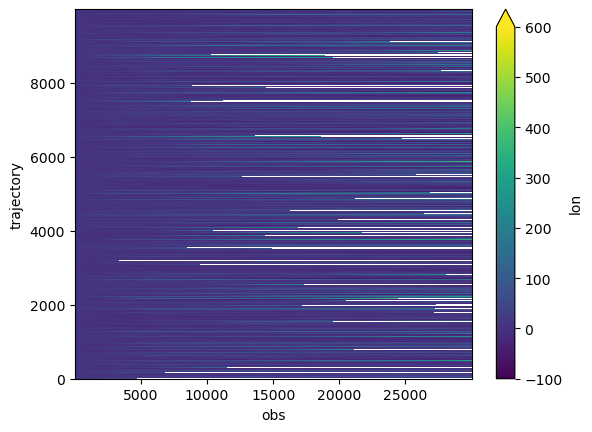

In [7]:
lon_unrolled.plot(vmin=-100, vmax=600)

In [28]:
print(ds_traj.lat.shape)
print(lon_unrolled.shape)

lon_unrolled.isel(obs=slice(None,2999))

(10000, 30000)
(10000, 29999)


<xarray.DataArray 'lon' (trajectory: 10000, obs: 2999)> Size: 240MB
dask.array<getitem, shape=(10000, 2999), dtype=float64, chunksize=(10000, 1), chunktype=numpy.ndarray>
Coordinates:
  * obs         (obs) int32 12kB 1 2 3 4 5 6 7 ... 2994 2995 2996 2997 2998 2999
  * trajectory  (trajectory) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999

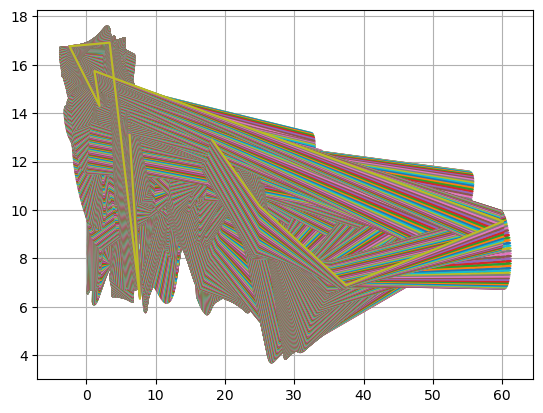

In [50]:
#individual trajectories  plot
#x histogram for the binin, use a coarse binning
loni = lon_unrolled.isel(trajectory=slice(0,10),obs=slice(0,2999))
lati = ds_traj.isel(trajectory=slice(0,10),obs=slice(0,2999)).lat
plt.plot(loni, lati)
         
plt.grid()

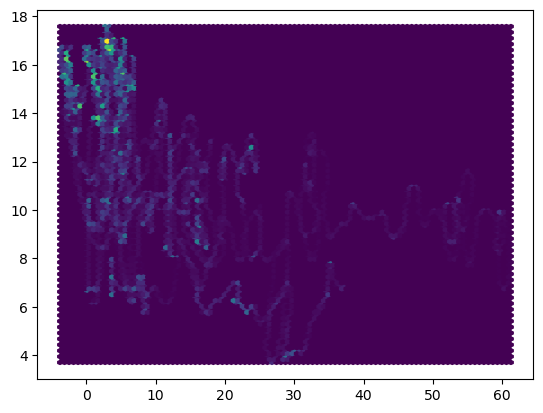

In [51]:
plt.hexbin(loni,lati)
plt.show()

In [ ]:
import numpy
data = numpy.random.random(100)
print(data)
bins = numpy.linspace(0, 1, 10)

digitized = numpy.digitize(data, bins)

print(bins)
print(digitized)

plt.plot(data)
plt.grid()

bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]

In [ ]:
#fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

# Big bins
plt.hist2d(loni, lati, bins=(50, 50), cmap=plt.cm.jet)
plt.title('bins = (50, 50)')
 

In [ ]:
loni = lon_unrolled.isel(obs=slice(0,2999))
lati = ds_traj.isel(obs=slice(0,2999)).lat

# Flatten loni and lati into 1D arrays
loni_flat = np.concatenate(loni)
lati_flat = np.concatenate(lati)

# Create a 2D histogram
plt.figure(figsize=(10, 8))
plt.hist2d(loni_flat, lati_flat, bins=(50, 50), cmap=plt.cm.jet)
plt.colorbar(label="Counts")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("2D Histogram of Particle Tracks")
plt.show()


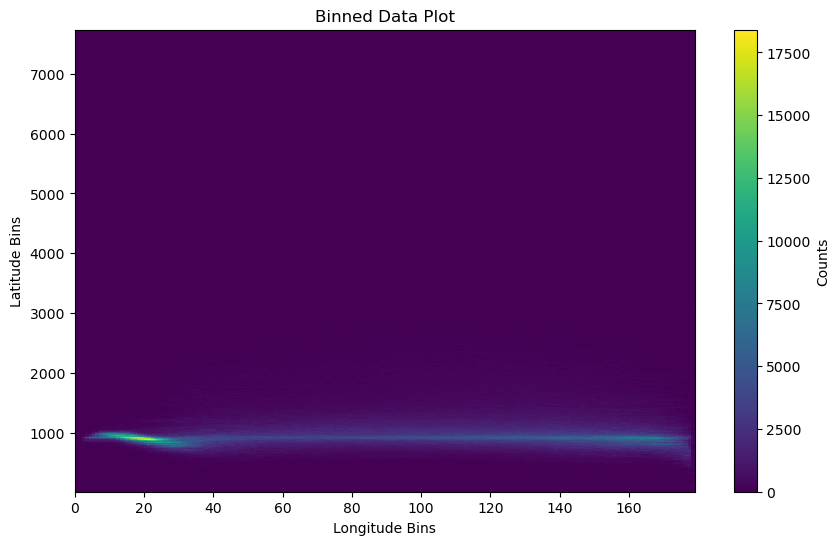

In [10]:
# # Extract longitude and latitude using the same dimensions
# lon_values = lon_unrolled.values.flatten()  # Flatten unrolled longitude
# lat_values = ds_traj.lat.values.flatten()   # Flatten latitude

# # Align shapes by masking both arrays
# min_length = min(len(lon_values), len(lat_values))
# lon_values = lon_values[:min_length]
# lat_values = lat_values[:min_length]

# # Filter out NaN values to ensure lengths match
# valid_mask = ~np.isnan(lon_values) & ~np.isnan(lat_values)
# lon_values_filtered = lon_values[valid_mask]
# lat_values_filtered = lat_values[valid_mask]

# # Bin the filtered data
# lon_indices = np.digitize(lon_values_filtered, lon_bins) - 1
# lat_indices = np.digitize(lat_values_filtered, lat_bins) - 1

# # Create a 2D histogram for the binned data
# H, xedges, yedges = np.histogram2d(lat_indices, lon_indices, bins=[len(lat_bins) - 1, len(lon_bins) - 1])

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.pcolormesh(xedges, yedges, H.T, cmap="viridis",vmin=0, vmax=)
# plt.colorbar(label="Counts")
# plt.xlabel("Longitude Bins")
# plt.ylabel("Latitude Bins")
# plt.title("Binned Data Plot")
# plt.show()


In [21]:
ds_traj.trajectory.isel(trajectory=1).data

array(1)

In [24]:
dens = np.zeros((Ny,Nx), dtype=int)
## check the error of the tranpositn
#for traj in ds_traj.trajectory.isel(trajectory=1).data:
lon_traj = lon_unrolled.sel(trajectory=1).compute().data
lat_traj = ds_traj.lat.sel(trajectory=1).compute().data
point_list = list(zip(      
        np.digitize(lat_traj, np.linspace(*lat_bds, Ny)).astype(int) -1,
        np.digitize(lon_traj, np.linspace(*lon_bds, int((pix_replica_lon[1] - pix_replica_lon[0]) * Nx))).astype(int)-1,
    ))

In [ ]:
dens = np.zeros((Ny,Nx), dtype=int)
## check the error of the tranpositn
for traj in tqdm.tqdm(ds_traj.trajectory.isel(trajectory=slice(None,None,1)).data):
    lon_traj = lon_unrolled.sel(trajectory=traj).compute().data
    lat_traj = ds_traj.lat.sel(trajectory=traj).compute().data
    point_list = list(zip(      
        np.digitize(lat_traj, np.linspace(*lat_bds, Ny)).astype(int) -1,
        np.digitize(lon_traj, np.linspace(*lon_bds, int((pix_replica_lon[1] - pix_replica_lon[0]) * Nx))).astype(int)-1,
    ))

    #drop the duplicates
    point_list = [i for i, j in zip_longest(point_list, point_list[1:]) if i !=j]
    pos,count = np.unique(np.array(line_between_sequence(point_list)), axis=0, return_counts = True)
    #wrap back to Nx and Ny
    pos = pos % [Ny,Nx]
    dens[*pos.T] +=count
    #break

In [ ]:
dens_array = xr.DataArray(
    dens,
    dims = ('lat','lon'),
    coords = {
        'lat':np.linspace(*lat_bds, Ny), 
        'lon':np.linspace(*lon_bds_base, Nx), 
    },
)

dens_array.plot.imshow(cmap=cm.thermal)


In [ ]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed
dens_array.plot.imshow(ax=ax, cmap=cm.thermal)
plt.title("Density Distribution", fontsize=16)  # Add a title if needed
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

# Save the figure
plt.savefig("particle_density.png", dpi=300, bbox_inches="tight")  # Save the figure
plt.show()